# Perculation Simulation

## The drawing table

First of all we have to create a grid of size L. With a $p$ probability that each of the squares inside the raster is occupied.
We will do this by creating a matrix where all the elements are initially zero and have a chance $p$ to be 1.

In [1]:
import numpy as np
import random
import time

In [2]:
import pixiedust

Pixiedust database opened successfully


In [3]:
#this function will give True or False to later determine what elements will be coloured in the grid.
def decision(probability):
    return random.random() < probability

In [4]:
def one_or_zero(el, probability):
    if decision(probability):
        return 1
    else:
        return 0

In [5]:
def create_world(size,probability):
    vector= np.zeros(size**2)  #create vector to make the iteration easier
    vector[:] = [one_or_zero(el,probability) for el in vector]   #make certain elements one and zero depending on the prob
    return vector.reshape(size,size)    #reshape the vector to a matrix

In [6]:
M=create_world(5,0.7)
M

array([[0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [7]:
from matplotlib import pyplot as plt
from matplotlib import colors

def draw_array(M):
    cmap = colors.ListedColormap(['White','Red'])
    plt.figure(figsize=(5,5))
    plt.pcolor(M[::-1],cmap=cmap,edgecolors='k', linewidths=0.1)
    plt.show()

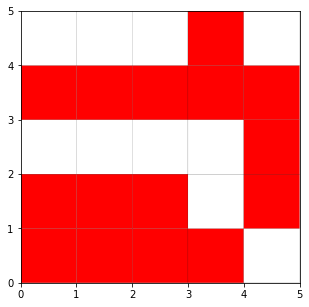

In [8]:
draw_array(M)

## How to count?

We will now implement an algoritm to count the amount of clusters in the grid. The method I have chosen is the Hoshen and Kopelman algortim.

The function below returns the number of clusters, the list in where the clusters are counted with their respective number of sites (negative means that this one is 'slorped' by another cluster), the matrix in which the different numbers can be shown,  the number of unoccupied sites and the number of the sites in the largest cluster.

In [9]:
def occupied(el):
    return el==1

In the method we have to keep up with the track of how the cluster size of a cluster. We do this by making a list. Which after several iterations look like this as an example:

In [10]:
np.array([3.,0.,3.,2.,1.])

array([3., 0., 3., 2., 1.])

Because of how indexing works in Python. In the above array we have that the amount of zeros is equal to 3. The amount of cluster 2 is 3, cluster 3 is 2 etc...

However, when two clusters meet, for example cluster 2 and 3 we merge the two clusters to the cluster of the upper one. The cluster size of 3 is transferred to cluster 2 and cluster two will be pointed to cluster 2.
And the list should look the following:

In [11]:
y=np.array([3.,0.,5.,-2.,1.])

And then when we get a new occupied space that is related to cluster 3, the new zone should be counted for for the 'true label' of cluster 3, which is cluster 2.
The following function helps us with that:

In [12]:
def get_true_label(value,lijst):
    if lijst[int(value)]>0:
        return value
    else:
        return get_true_label(-lijst[int(value)], lijst)

In [13]:
get_true_label(3,y)

2.0

When the upper cluster $\textit{already}$ is pointed to another cluster we still et the true label:

In [14]:
get_true_label(4,np.array([3.,0.,5.,-2.,-3.]))

2.0

The next function works the same way but instead it returns the value, it returns the cluster size of the 'true label'- cluster. This is needed when the cluster is being assigned, is already pointed to another cluster. 

In [15]:
def get_true_label_value(value,lijst):
    if lijst[int(value)]>0:
        return lijst[int(value)]
    else:
        return get_true_label_value(-lijst[int(value)], lijst)

In [16]:
x=np.array([3.,0.,5.,-2.,-2.])
get_true_label_value(4,x)

5.0

Next function counts one for the true cluster if nothing is being merged or anything.

In [17]:
def count_true_cluster(cell,lijst):
    label=get_true_label(cell,lijst)
    lijst[int(label)]+=1

Now we have everything for the algoritm.

In [18]:
def Hoshen_and_Kopelman(matrix):
    U=np.copy(matrix)
    l=2
    lijst =np.zeros(round((len(matrix)**2)/2))
    if occupied(U[0,0]):  #first element
        U[0,0]=l
        lijst[l]+=1
        l+=1
    else:
        lijst[0]+=1
        
    for j in range(len(U[0,:])-1): #top row
        j+=1
        if occupied(U[0,j]):
            if U[0,j-1]!=0:         #look left
                U[0,j]=U[0,j-1]
                lijst[int(U[0,j-1])]+=1.
            else:
                U[0,j]=l
                lijst[l]+=1
                l+=1
        else:
            lijst[0]+=1
    for i in range(len(U[0,:])-1):
        i+=1
        for j in range(len(U[:,0])):
            if j==0:                           #first column does not have to look left
                if occupied(U[i,0]):
                    if U[i-1,0]!=0:           #look up
                        U[i,0]=U[i-1,0]
                        count_true_cluster(U[i,0],lijst)
                    else:
                        U[i,0]=l
                        lijst[l]+=1
                        l+=1
                else:
                    lijst[0]+=1
            

            elif occupied(U[i,j]):                
                if U[(i-1),j]!=0:            #look up
                    U[i,j]=U[i-1,j]
                    count_true_cluster(U[i,j],lijst)
                        
                    if U[i,j-1]!=0:             #look left AND right to merge
                        if get_true_label(U[i,j],lijst)!=get_true_label(U[i,j-1],lijst):  #if both elements are from the same cluster, mer
                                
#                               #below is the tricky part, we have to add the true label size! of left to cluster of the current one (=cluster of top one)
                                lijst[int(get_true_label(U[i,j],lijst))]+=(get_true_label_value(U[i,j-1], lijst)) 
                                lijst[int(get_true_label(U[i,j-1],lijst))]=-U[i,j] #and now the true label of left becomes the current one
             
                elif U[i,j-1]!=0:         #look left
                    U[i,j]=U[i,j-1]
                    count_true_cluster(U[i,j],lijst)
                    
                else:
                    U[i,j]=l
                    lijst[l]+=1
                    l+=1
            else:
                lijst[0]+=1
          
        
    number_of_clusters= sum([i>0 for i in lijst[1:]])
    number_of_unoccupied_sites=lijst[0]
    largest_cluster=max(lijst[1:])
    fraction=largest_cluster/(len(matrix)**2)
    return [number_of_clusters, lijst, U, number_of_unoccupied_sites, largest_cluster, fraction]

Hoshen_and_Kopelman(M)

[2,
 array([10.,  0.,  8., -2.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([[0., 0., 0., 2., 0.],
        [3., 3., 3., 2., 2.],
        [0., 0., 0., 0., 2.],
        [4., 4., 4., 0., 2.],
        [4., 4., 4., 4., 0.]]),
 10.0,
 8.0,
 0.32]

## Example

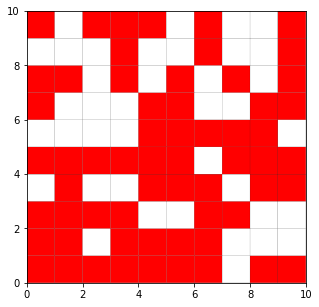

In [19]:
M=create_world(10,0.6)
small_world=Hoshen_and_Kopelman(M)
draw_array(M)

Number of clusters:

In [20]:
small_world[0]

7

Largest cluster size:

In [21]:
small_world[4]

47.0

## Time

In [22]:
M=create_world(300,0.7)
# draw_array(M)
toc= time.time()
HK=Hoshen_and_Kopelman(M)
tic = time.time()
t=tic-toc
t

11.234416246414185

In [23]:
HK[5]

0.6899666666666666

In [24]:
def smiley():
    S=np.zeros(6*8).reshape(6,8)
    S[1,2]=1
    S[1,5]=1
    S[-3,1]=1
    S[-2,2:6]=1
    S[-3,6]=1
    draw_array(S)

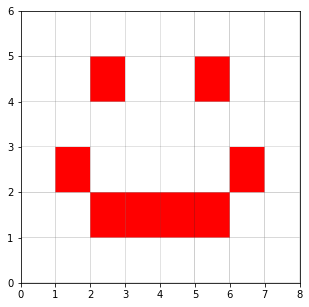

In [25]:
smiley()

## Perculation

In [31]:
var_p=np.linspace(0,1,num=100)

In [32]:
def perculation(x,size):
    occupation=[]
    for p in x:
        M=create_world(size,p)
        occupation.append(Hoshen_and_Kopelman(M)[5])
    return occupation

In [34]:
toc= time.time()
occupation =perculation(var_p,300)
tic = time.time()
tic-toc

372.6174008846283

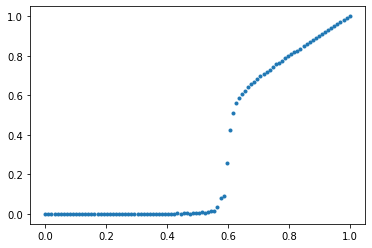

In [35]:
plt.plot(var_p,occupation,'.')
plt.show()